# **Transfer learning with fine-tuned deep CNN ResNet50 model for classifying COVID-19 from chest X-ray images**

In [41]:
# # Unzip files
# !unzip COVID.zip -d COVID_data

In [42]:
# # Alternative
# import opendatasets as op
# op.download("https://www.kaggle.com/tawsifurrahman/covid19-radiography-database")

### Import libraries

In [61]:
import os
import cv2
import glob
import torch
import shutil
import itertools
import torch.nn as nn
import torch.optim as optim
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from torch.nn import functional as F
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler
from torchvision.utils import make_grid
from PIL import Image
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### Load images

In [2]:
covid_path = 'COVID_data/COVID-19_Radiography_Dataset/COVID/images'
normal_path = 'COVID_data/COVID-19_Radiography_Dataset/Normal/images'

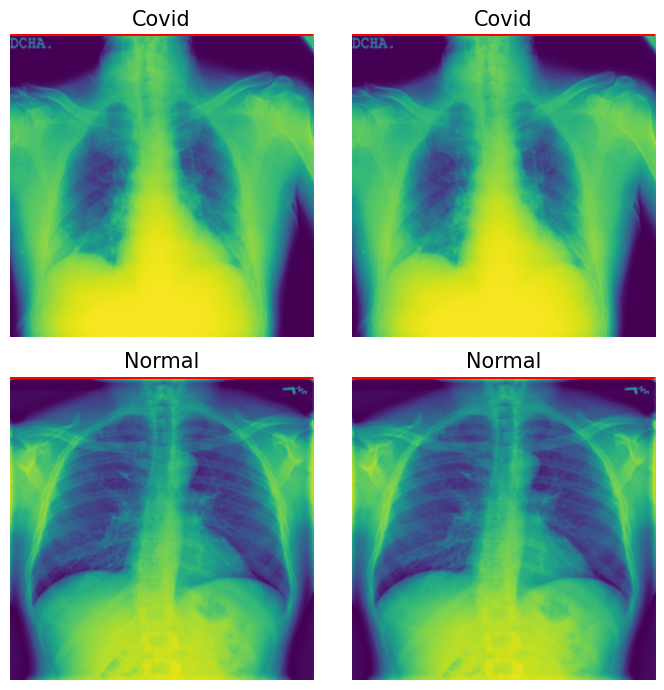

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
labels = ['Covid','Normal']
folders = [covid_path, normal_path]

i = 0
j = 0
k = 0

# Loop through each row of subplots
for row in axes:
    # Get the current folder
    folder = folders[k]
    # Loop through each subplot in the row
    for plot in row:
    
        # List all files in the folder
        image_files = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
        # Check if there are more images in the folder
        if j < len(image_files):
            # Construct the full path to the image
            image_path = os.path.join(folder, image_files[j])

            # Read the image using OpenCV
            img = cv2.imread(image_path, 0)  # Assuming grayscale images

            # Display the image
            plot.imshow(img)

            # Customize the subplot
            plot.axhline(y=0.5, color='r')
             # Ensure the index is within the range of labels
            label_index = j % len(labels)
            plot.set_title(labels[label_index], fontsize=15)
            plot.axis('off')

            # Increment counters
            i += 1

    # Reset label index for the next row
    i = 0
    j += 1
    k += 1
    
fig.tight_layout()
plt.show()

### Create Train and Test set

In [148]:
os.mkdir('COVID_data/working/train/Covid')
os.mkdir('COVID_data/working/test/Covid')

os.mkdir('COVID_data/working/train/Normal')
os.mkdir('COVID_data/working/test/Normal')


In [149]:
covid_train_len = int(np.floor(len(os.listdir(covid_path))*0.8))
covid_len = len(os.listdir(covid_path))

normal_train_len = int(np.floor(len(os.listdir(normal_path))*0.8))
normal_len = len(os.listdir(normal_path))

In [150]:
for trainimg in itertools.islice(glob.iglob(os.path.join(covid_path, '*.png')), covid_train_len):
    shutil.copy(trainimg, 'COVID_data/working/train/Covid')

    
for trainimg in itertools.islice(glob.iglob(os.path.join(normal_path, '*.png')), normal_train_len):
    shutil.copy(trainimg, 'COVID_data/working/train/Normal')
    
    
for testimg in itertools.islice(glob.iglob(os.path.join(covid_path, '*.png')), covid_train_len, covid_len):
    shutil.copy(testimg, 'COVID_data/working/test/Covid')

    
for testimg in itertools.islice(glob.iglob(os.path.join(normal_path, '*.png')), normal_train_len, normal_len):
    shutil.copy(testimg, 'COVID_data/working/test/Normal')

### Visualize train and test set

<Axes: >

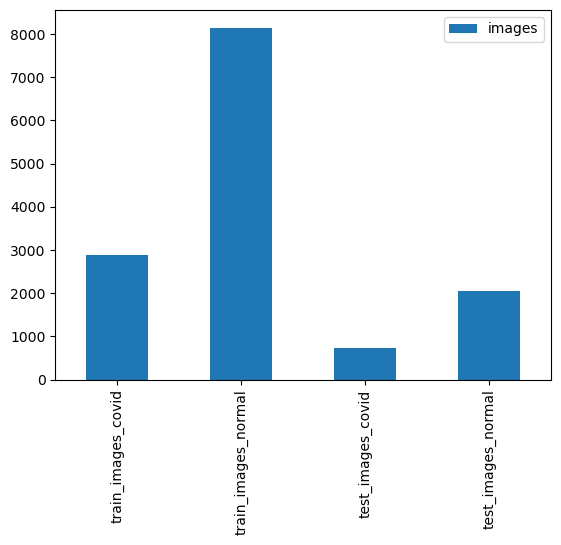

In [153]:
train_images_covid = len(os.listdir('COVID_data/working/train/Covid'))
train_images_normal = len(os.listdir('COVID_data/working/train/Normal'))             
test_images_covid = len(os.listdir('COVID_data/working/test/Covid'))
test_images_normal = len(os.listdir('COVID_data/working/test/Normal'))

data_info = pd.DataFrame(data = [train_images_covid,train_images_normal,
                                 test_images_covid,test_images_normal],
                         index = ['train_images_covid','train_images_normal',
                                 'test_images_covid','test_images_normal'],
                         columns = ['images'])

data_info.plot(kind='bar')

The data is imbalanced => Use upsampling to solve the problem

In [4]:
train_transform = transforms.Compose([
                    transforms.Resize(224),
                    transforms.RandomResizedCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

val_transform = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])

data_dir = 'COVID_data/working/'

train_dataset = ImageFolder(data_dir + 'train', train_transform)
val_dataset = ImageFolder(data_dir + 'test', val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=20, 
                              num_workers=2, sampler=ImbalancedDatasetSampler(train_dataset))

val_dataloader = DataLoader(val_dataset, batch_size=20, 
                              num_workers=2, sampler=ImbalancedDatasetSampler(val_dataset))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


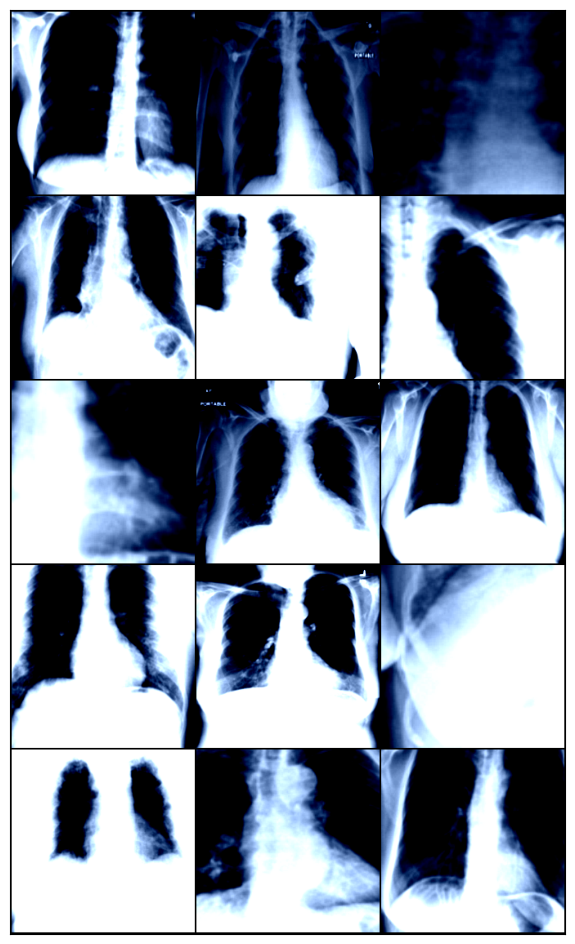

In [5]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:15], nrow=3).permute(1, 2, 0))
        break
        
show_batch(train_dataloader)

### Early Stopping

In [6]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
    
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Fit Function

In [47]:
def fit(model, batch_size, patience, n_epochs):
    
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):
        
        model.train()
        for batch, (data, target) in enumerate(train_dataloader, 1):
            
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
          
            output = model(data)
          
            loss = criterion(output, target)
            
            loss.backward()
          
            optimizer.step()
        
            train_losses.append(loss.item())

      
        model.eval()
        for data, target in val_dataloader:
            data = data.to(device)
            target = target.to(device)
           
            output = model(data)
         
            loss = criterion(output, target)
            
            valid_losses.append(loss.item())
            
        
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print("Epoch: {}/{}, train_loss: {:4f}, val_loss: {:4f}".format(epoch, n_epochs, train_loss, valid_loss))
        
        train_losses = []
        valid_losses = []
        
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

### Build Model

In [48]:
# Initiaizing ResNet50 Model
model = models.resnet50(pretrained=True)

# Freezing layers of resnet model so it won't be trained
for param in model.parameters():
    param.requires_grad = False

# Configuring fully connected layer to classify two classes
num_ftrs = model.fc.in_features        
model.fc = nn.Sequential(nn.Linear(num_ftrs, 1024),
                         nn.BatchNorm1d(1024),
                         nn.ReLU(),
                         nn.Dropout(0.25),
                         nn.Linear(1024, 2))

print(model)

# Moving model to device(cpu or gpu)
model = model.to(device)

# Defining loss function
criterion = nn.CrossEntropyLoss()

# Defining optimizer
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Monitor Training time

In [49]:
from datetime import datetime

def timer(start_time=None):
  #function to track time
  if not start_time:
    print(datetime.now())
    start_time = datetime.now()
    return start_time
  elif start_time:
    thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
    tmin, tsec = divmod(temp_sec, 60)
    print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### Train model

In [50]:
start_time=timer(None)

model, train_loss, val_loss = fit(model, batch_size=32, patience=5, n_epochs=20)

timer(start_time)

2023-12-20 11:56:05.014928
Epoch: 1/20, train_loss: 0.428441, val_loss: 0.304979
Validation loss decreased (inf --> 0.304979).  Saving model ...
Epoch: 2/20, train_loss: 0.338249, val_loss: 0.271325
Validation loss decreased (0.304979 --> 0.271325).  Saving model ...
Epoch: 3/20, train_loss: 0.344720, val_loss: 0.343075
EarlyStopping counter: 1 out of 5
Epoch: 4/20, train_loss: 0.308294, val_loss: 0.251408
Validation loss decreased (0.271325 --> 0.251408).  Saving model ...
Epoch: 5/20, train_loss: 0.304462, val_loss: 0.242580
Validation loss decreased (0.251408 --> 0.242580).  Saving model ...
Epoch: 6/20, train_loss: 0.297458, val_loss: 0.215424
Validation loss decreased (0.242580 --> 0.215424).  Saving model ...
Epoch: 7/20, train_loss: 0.298169, val_loss: 0.235358
EarlyStopping counter: 1 out of 5
Epoch: 8/20, train_loss: 0.292562, val_loss: 0.267577
EarlyStopping counter: 2 out of 5
Epoch: 9/20, train_loss: 0.277685, val_loss: 0.232762
EarlyStopping counter: 3 out of 5
Epoch: 10/2

### Save Model

In [51]:
torch.save(model, 'ResNet50_COVID_19_Pytorch.h5')

Let’s define some variables, transformations on test set(same as that of training set), softmax function to pick highest probability from model outputs.

In [52]:
TEST_COVID_PATH = 'COVID_data/working/test/Covid/'
TEST_NON_COVID_PATH = 'COVID_data/working/test/Normal/'
imsize = 224
thresh = 0.5  


test_loader = transforms.Compose([transforms.Resize(imsize), 
                             transforms.CenterCrop(224), 
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                             ])

softmax = torch.nn.Softmax()
class_names = ['Covid','Normal']

Now it’s time to analyze our model. For doing so we will define a function which will convert images to tensor for our model to work on.

Another thing we will define is the metrics to evaluate our model. We will not use accuracy as our metric as it is not ideal when dealing with imbalanced dataset. To understand why, let’s assume we have a dataset where there is 9 examples in Class A and 1 example in Class B. Now even if our model is poor, it has 90% chances of choosing correct class which means it can have 90% accuracy. It is obviously misleading in terms of analyzing our model. Thus we will use another pair of metric called sensitivity and specificity.

Sensitivity (also called the true positive rate, the recall) measures the proportion of actual positives that are correctly identified as such (e.g., the percentage of sick people who are correctly identified as having the condition).

Specificity (also called the true negative rate) measures the proportion of actual negatives that are correctly identified as such (e.g., the percentage of healthy people who are correctly identified as not having the condition).

In [53]:
def image_to_tensor(image_name):
    image = Image.open(image_name).convert("RGB")
    image = test_loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0) 
    return image

def find_sens_spec(covid_prob, non_covid_prob, thresh):
    sensitivity= (covid_prob >= thresh).sum()   / (len(covid_prob)+1e-10)
    specificity= (non_covid_prob < thresh).sum() / (len(non_covid_prob)+1e-10)
    print("sensitivity = %.3f, specificity = %.3f" %(sensitivity,specificity))
    return sensitivity, specificity

In [54]:
model = torch.load('./ResNet50_COVID_19_Pytorch.h5', map_location='cpu') 
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Next up, we will use glob to convert test directory to a list, so that we can iterate over images in list and predict the class of each image.

In [55]:
test_covid  = glob.glob("%s*" %TEST_COVID_PATH)
test_non_covid   = glob.glob("%s*" %TEST_NON_COVID_PATH)

covid_predictions = np.zeros([len(test_covid),1]).astype(int)
non_covid_predictions  = np.zeros([len(test_non_covid),1]).astype(int)

covid_prob = np.zeros([len(test_covid),1])
non_covid_prob   = np.zeros([len(test_non_covid),1])

### Covid Test

In [56]:
for i in range(len(test_covid)):
    img = image_to_tensor(test_covid[i])
    output = model(img)
    _, pred = output.max(1, keepdim=True)
    prob = softmax(output)
    covid_prob[i,:]= prob.data.numpy()[0,0]
    print("{} Actual - Covid, Predicted - {} with probability - {}".format(i, class_names[int(pred.data.numpy())], prob.data.numpy()))

/home/bakhoin1/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 Actual - Covid, Predicted - Covid with probability - [[9.999950e-01 4.951294e-06]]
1 Actual - Covid, Predicted - Covid with probability - [[9.9938381e-01 6.1620795e-04]]
2 Actual - Covid, Predicted - Covid with probability - [[0.9974375  0.00256252]]
3 Actual - Covid, Predicted - Covid with probability - [[0.97726804 0.022732  ]]
4 Actual - Covid, Predicted - Covid with probability - [[0.6597247  0.34027535]]
5 Actual - Covid, Predicted - Covid with probability - [[0.98662484 0.01337518]]
6 Actual - Covid, Predicted - Covid with probability - [[9.996588e-01 3.411296e-04]]
7 Actual - Covid, Predicted - Covid with probability - [[9.9915504e-01 8.4489671e-04]]
8 Actual - Covid, Predicted - Covid with probability - [[0.98588574 0.01411424]]
9 Actual - Covid, Predicted - Covid with probability - [[0.9698253  0.03017469]]
10 Actual - Covid, Predicted - Covid with probability - [[0.7918234 0.2081766]]
11 Actual - Covid, Predicted - Covid with probability - [[0.7670916  0.23290847]]
12 Actua

### Normal Test

In [57]:
for i in range(len(test_non_covid)):
    img= image_to_tensor(test_non_covid[i])
    output= model(img)
    _, pred = output.max(1, keepdim=True)
    prob = softmax(output)
    non_covid_prob[i,:]= prob.data.numpy()[0,0]
    print("{} Actual - Normal, Predicted - {} with probability - {}".format(i, class_names[int(pred.data.numpy())], prob.data.numpy()))

0 Actual - Normal, Predicted - Normal with probability - [[3.9574908e-04 9.9960428e-01]]
1 Actual - Normal, Predicted - Normal with probability - [[0.0194501 0.9805499]]
2 Actual - Normal, Predicted - Normal with probability - [[0.07903588 0.9209641 ]]
3 Actual - Normal, Predicted - Normal with probability - [[0.3420406 0.6579594]]
4 Actual - Normal, Predicted - Normal with probability - [[0.00137671 0.99862325]]
5 Actual - Normal, Predicted - Normal with probability - [[0.06899656 0.9310034 ]]
6 Actual - Normal, Predicted - Normal with probability - [[0.01162367 0.9883763 ]]
7 Actual - Normal, Predicted - Normal with probability - [[0.06807192 0.9319281 ]]
8 Actual - Normal, Predicted - Normal with probability - [[0.04344139 0.95655864]]
9 Actual - Normal, Predicted - Normal with probability - [[0.01524838 0.98475164]]
10 Actual - Normal, Predicted - Normal with probability - [[0.08344719 0.9165528 ]]
11 Actual - Normal, Predicted - Normal with probability - [[0.00486962 0.9951304 ]]


### Calculate Sensitivity and Specificity

In [58]:
covid_predictions = np.where(covid_prob  > thresh, 1, 0)
non_covid_predictions = np.where(non_covid_prob  > thresh, 1, 0)
    
sensitivity, specificity = find_sens_spec(covid_prob, non_covid_prob, thresh)

sensitivity = 0.919, specificity = 0.956


### Plot confusion matrix

<Axes: >

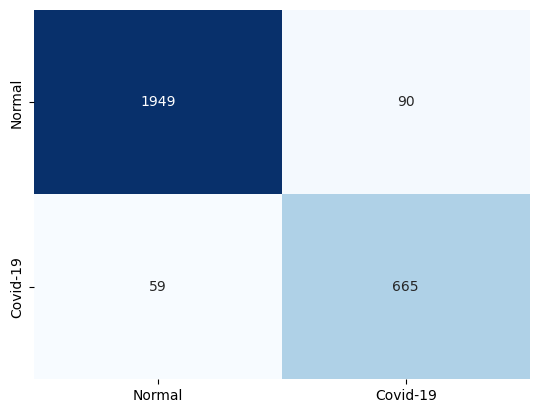

In [59]:
covid_list = [int(covid_predictions[i]) for i in range(len(covid_predictions))]
non_covid_list = [int(non_covid_predictions[i]) for i in range(len(non_covid_predictions))]

y_pred_list = covid_list + non_covid_list
y_test_list = [1 for i in range(len(covid_list))] + [0 for i in range(len(non_covid_list))]

y_pred = np.asarray(y_pred_list, dtype=np.int64)
y_test = np.asarray(y_test_list, dtype=np.int64)

cnf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(cnf_matrix, cmap=plt.cm.Blues, annot=True, cbar=False, fmt='g', xticklabels= ['Normal','Covid-19'], yticklabels= ['Normal','Covid-19'])

We have some Type II Errors, which is very fatal in  medical modelling

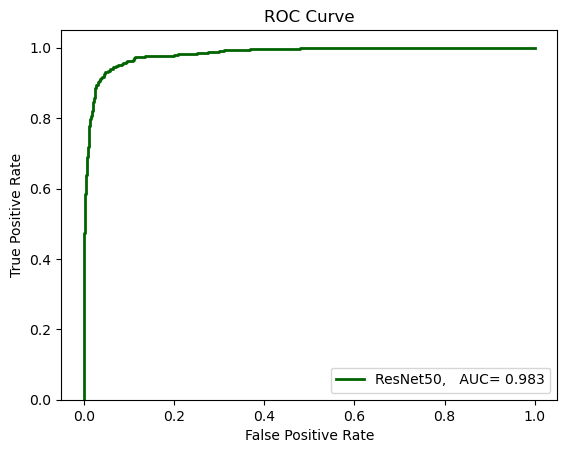

In [62]:
y_test_roc= [1 for i in range(len(covid_prob))]+[0 for i in range(len(non_covid_prob))]
y_pred_roc= [covid_prob[i] for i in range(len(covid_prob))]+[non_covid_prob[i] for i in range(len(non_covid_prob))]

auc_score = roc_auc_score(y_test_roc, y_pred_roc)
false_postive_rate, true_positive_rate, _ = roc_curve(y_test_roc, y_pred_roc)

plt.figure()
plt.plot(false_postive_rate, true_positive_rate,  color='darkgreen', linewidth=2,   label='ResNet50,   AUC= %.3f' %auc_score)
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend(loc='lower right')